In [1]:
import sys
import pyodbc
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import datetime

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Rectangle
from matplotlib.patches import Arrow

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, HBox
import ipywidgets as widgets

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_columns', None)

%load_ext autotime

#!pip install ffn
import ffn

In [2]:
lukeMurrel = pd.read_csv('lm.csv', header=0)
lukeMurrel['DATE']  = pd.to_datetime(lukeMurrel['DATE'], format='%d-%m-%y')
lukeMurrelFiltered = lukeMurrel[['DATE','UNITS INVESTED', 'UNITS COLLECTED', 'P/L']]
lukeMurrelFilteredAndGrouped = lukeMurrelFiltered.groupby(['DATE']).sum()
lukeMurrelFilteredAndGrouped = lukeMurrelFilteredAndGrouped.resample('D').sum().replace(np.nan, 0)
lukeMurrelFilteredAndGrouped['Cum P/L'] = lukeMurrelFilteredAndGrouped['P/L'].cumsum(axis = 0)+100 #start at 100 bank account
lukeMurrelFilteredAndGrouped['High P/L'] = lukeMurrelFilteredAndGrouped['Cum P/L'].cummax()
lukeMurrelFilteredAndGrouped['Drawdown'] = (lukeMurrelFilteredAndGrouped['Cum P/L'] - lukeMurrelFilteredAndGrouped['High P/L']) 
lukeMurrelFilteredAndGrouped.head()

,UNITS INVESTED,UNITS COLLECTED,P/L,Cum P/L,High P/L,Drawdown
DATE,,,,,,
2014-01-01,6.0,9.4,3.4,103.4,103.4,0.0
2014-01-02,0.0,0.0,0.0,103.4,103.4,0.0
2014-01-03,0.0,0.0,0.0,103.4,103.4,0.0
2014-01-04,8.5,4.5,-4.0,99.4,103.4,-4.0
2014-01-05,0.0,0.0,0.0,99.4,103.4,-4.0


time: 98 ms


In [3]:
trialSpy = pd.read_csv('ts.csv', header=0)
trialSpy['DATE']  = pd.to_datetime(trialSpy['DATE'], format='%d/%m/%Y')
trialSpyFiltered = trialSpy[['DATE','UNITS INVESTED', 'UNITS COLLECTED', 'P/L']]
trialSpyFiltered = trialSpyFiltered[(trialSpyFiltered['DATE']>datetime.date(2013,12,31)) & (trialSpyFiltered['DATE']<datetime.date(2019,3,11))] #filter to same time peroid as Murrel tips
trialSpyFilteredAndGrouped = trialSpyFiltered.groupby(['DATE']).sum()
trialSpyFilteredAndGrouped = trialSpyFilteredAndGrouped.resample('D').sum().replace(np.nan, 0)
trialSpyFilteredAndGrouped['Cum P/L'] = trialSpyFilteredAndGrouped['P/L'].cumsum(axis = 0)+100 #start at 100 bank account
trialSpyFilteredAndGrouped['High P/L'] = trialSpyFilteredAndGrouped['Cum P/L'].cummax()
trialSpyFilteredAndGrouped['Drawdown'] = (trialSpyFilteredAndGrouped['Cum P/L'] - trialSpyFilteredAndGrouped['High P/L']) 
trialSpyFilteredAndGrouped.head()

,UNITS INVESTED,UNITS COLLECTED,P/L,Cum P/L,High P/L,Drawdown
DATE,,,,,,
2014-01-01,10.70,10.20,-0.50,99.50,99.50,0.00
2014-01-02,3.10,6.08,2.98,102.48,102.48,0.00
2014-01-03,6.05,5.20,-0.85,101.63,102.48,-0.85
2014-01-04,12.10,5.06,-7.04,94.59,102.48,-7.89
2014-01-05,4.35,0.00,-4.35,90.24,102.48,-12.24


time: 177 ms


In [4]:
combined = pd.DataFrame()
combined['Cum P/L'] =  trialSpyFilteredAndGrouped['Cum P/L'] + lukeMurrelFilteredAndGrouped['Cum P/L']
combined['High P/L'] = combined['Cum P/L'].cummax()
combined['Drawdown'] = (combined['Cum P/L'] - combined['High P/L']) 

time: 12 ms


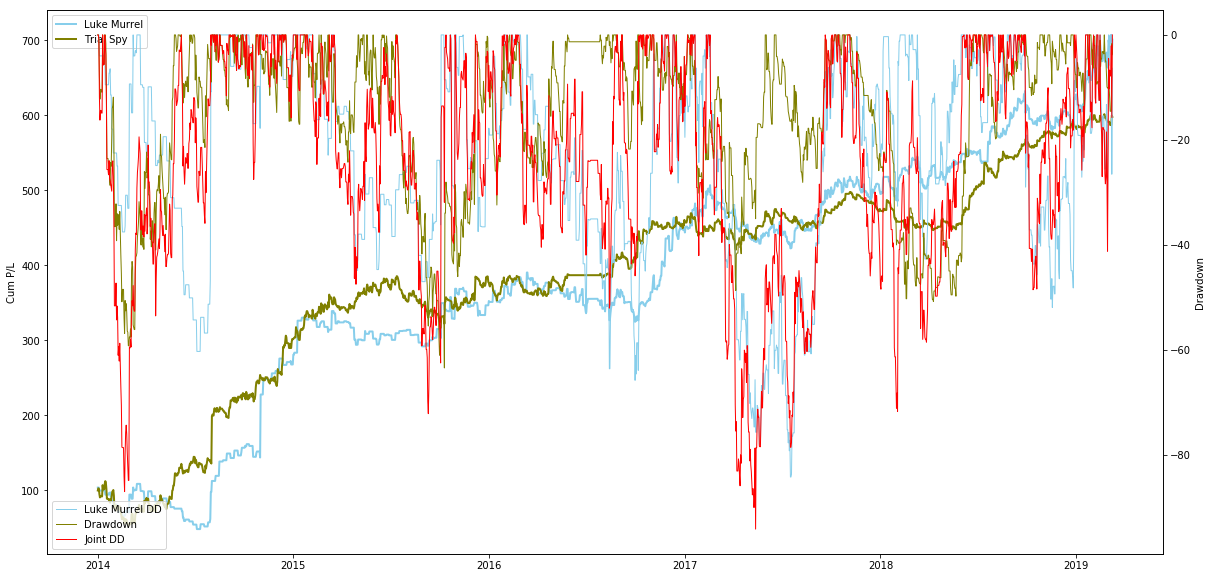

time: 567 ms


In [5]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()

ax1.plot( lukeMurrelFilteredAndGrouped.index.to_pydatetime(), lukeMurrelFilteredAndGrouped['Cum P/L'], color='skyblue', linewidth=2, label='Luke Murrel')
ax2.plot( lukeMurrelFilteredAndGrouped.index.to_pydatetime(), lukeMurrelFilteredAndGrouped['Drawdown'], color='skyblue', linewidth=1, label='Luke Murrel DD')
ax1.plot( trialSpyFilteredAndGrouped.index.to_pydatetime(), trialSpyFilteredAndGrouped['Cum P/L'], color='olive', linewidth=2, label='Trial Spy')
ax2.plot( trialSpyFilteredAndGrouped.index.to_pydatetime(), trialSpyFilteredAndGrouped['Drawdown'], color='olive', linewidth=1)

ax2.plot( combined.index.to_pydatetime(), combined['Drawdown'], color='red', linewidth=1, label='Joint DD')

ax1.set_ylabel('Cum P/L')
ax2.set_ylabel('Drawdown')

ax1.legend()
ax2.legend()

plt.show()

In [6]:
lmPerf = lukeMurrelFilteredAndGrouped['Cum P/L'].calc_stats()
lmPerf.display()

Stats for Cum P/L from 2014-01-01 00:00:00 - 2019-03-10 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
577.75%             0.78  44.63%  -55.67%

Annualized Returns:
mtd    3m      6m      ytd     1y      3y      5y      10y     incep.
-----  ------  ------  ------  ------  ------  ------  ------  --------
3.58%  15.80%  15.02%  12.77%  31.04%  24.20%  47.77%  44.63%  44.63%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.78     0.93       2.35
mean    33.09%   56.12%     21.51%
vol     42.61%   60.43%     9.15%
skew    12.49    3.00       -0.44
kurt    253.04   11.15      -2.99
best    58.52%   80.51%     29.77%
worst   -11.83%  -28.28%    10.74%

Drawdowns:
max      avg       # days
-------  ------  --------
-55.67%  -5.48%     31.58

Misc:
---------------  -------
avg. up month    11.40%
avg. down month  -5.27%
up year %        100.0

C:\ProgramData\Anaconda3\lib\site-packages\ffn\core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)
C:\ProgramData\Anaconda3\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [7]:
tsPerf = trialSpyFilteredAndGrouped['Cum P/L'].calc_stats()
tsPerf.display()

Stats for Cum P/L from 2014-01-01 00:00:00 - 2019-03-10 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
500.82%             0.84  41.31%  -52.88%

Annualized Returns:
mtd    3m     6m     ytd    1y      3y      5y      10y     incep.
-----  -----  -----  -----  ------  ------  ------  ------  --------
1.05%  3.83%  9.38%  2.33%  31.36%  17.81%  60.66%  41.31%  41.31%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  0.84     1.01       1.33
mean    29.61%   45.89%     15.17%
vol     35.10%   45.32%     11.42%
skew    6.15     1.60       -0.56
kurt    125.02   9.77       -3.23
best    46.64%   62.56%     25.38%
worst   -18.53%  -43.04%    2.33%

Drawdowns:
max      avg       # days
-------  ------  --------
-52.88%  -3.45%     20.42

Misc:
---------------  -------
avg. up month    8.69%
avg. down month  -3.89%
up year %        100.00%
12m up 

C:\ProgramData\Anaconda3\lib\site-packages\ffn\core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)
C:\ProgramData\Anaconda3\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)


In [8]:
combinedPerf = (trialSpyFilteredAndGrouped['Cum P/L'] + lukeMurrelFilteredAndGrouped['Cum P/L']).calc_stats()
combinedPerf.display()

Stats for Cum P/L from 2014-01-01 00:00:00 - 2019-03-10 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR    Max Drawdown
--------------  --------  ------  --------------
540.02%             1.09  43.04%  -41.84%

Annualized Returns:
mtd    3m     6m      ytd    1y      3y      5y      10y     incep.
-----  -----  ------  -----  ------  ------  ------  ------  --------
2.40%  9.96%  12.35%  7.71%  31.18%  21.09%  52.91%  43.04%  43.04%

Periodic:
        daily    monthly    yearly
------  -------  ---------  --------
sharpe  1.09     1.27       1.81
mean    27.74%   45.20%     18.31%
vol     25.50%   35.68%     10.12%
skew    7.61     1.76       -0.55
kurt    136.21   8.15       -3.22
best    33.42%   47.23%     27.31%
worst   -10.20%  -29.06%    6.90%

Drawdowns:
max      avg       # days
-------  ------  --------
-41.84%  -2.19%      16.7

Misc:
---------------  -------
avg. up month    7.20%
avg. down month  -3.45%
up year %        100.00%
12m 

C:\ProgramData\Anaconda3\lib\site-packages\ffn\core.py:2054: RuntimeWarning: invalid value encountered in minimum
  negative_returns = np.minimum(returns, 0.)
C:\ProgramData\Anaconda3\lib\site-packages\ffn\core.py:2056: RuntimeWarning: divide by zero encountered in true_divide
  res = np.divide(er.mean(), std)
